In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances, euclidean_distances
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import pearsonr
from skbio.stats.distance import mantel
from sklearn.model_selection import KFold

In [3]:
params_to_work_with = constants.ALL_PARAMS
ctx_outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB', 'H023_IN', 'H061_SE']
pd_outliers = ['PD028_YO', 'PD037_ES', 'PD044_TS', 'PD056_YK', 'PD004_KC']

In [19]:
def load_data(data_path, rois, outliers=[], data_cols=['subjects', 'Age', 'Gender'], remove_slopes=False):
    subjects_raw_data = DataProcessor(
        data_path, rois, rois, data_cols).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, rois, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    
    if remove_slopes:
        chosen_data = chosen_data.drop(columns=constants.SLOPES)
        
    return chosen_data


def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data

def show_corr_mean(data_groups, clusters_rois, curve=False):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)

    for (corr, title, color, error_data) in data_groups:
        corr_copy = corr.copy()
        np.fill_diagonal(corr_copy.values, 0)
        corr_mean = corr_copy.apply(np.mean, axis=1).to_numpy()

        ax.scatter(clusters_rois, corr_mean, color=color, s=20, alpha=0.7, label=title)
        
        if curve:
            ax.plot(clusters_rois, corr_mean, color=color)

        ax.set_xticks(clusters_rois)
        ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=8)
    
        if error_data:
            add_error_bar(clusters_rois, corr_mean, error_data['lower_ci'], error_data['upper_ci'],  ax, color, title)

    # # Connecting the points with vertical lines
    # for x, y1, y2 in zip(clusters_rois, corr_mean1.to_numpy(), corr_mean2.to_numpy()):
    #     plt.plot([x, x], [y1, y2], color='gray', linestyle='--')

    # ax.set_facecolor('white')
    ax.grid(True)
    ax.legend()

def add_error_bar(x_axis, means, lower_ci, upper_ci, ax, color, title=''):
    lower_ci = lower_ci.apply(np.mean, axis=1).to_numpy()
    upper_ci = upper_ci.apply(np.mean, axis=1).to_numpy()
    
    # Calculate error bars
    lower_errors = [mean - lower for mean, lower in zip(means, lower_ci)]
    upper_errors = [upper - mean for mean, upper in zip(means, upper_ci)]
    errors = [lower_errors, upper_errors]

    ax.errorbar(x_axis, means, yerr=errors, ecolor=color, label=f'{title} CI', linestyle='', alpha=0.5)


In [5]:
%autoreload 2

all_ctx_data_z_score= load_data(
    constants.PATH_TO_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers,
    remove_slopes=True)

young_ctx_data_z_score, old_ctx_data_z_score = StatisticsWrapper.seperate_data_to_two_groups(
        all_ctx_data_z_score, 'Age', constants.AGE_THRESHOLD)
print(
    f'num young: {young_ctx_data_z_score.subjects.nunique()}, num old: {old_ctx_data_z_score.subjects.nunique()}')

pd_col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
all_pd_data_z_score= load_data(
    constants.PATH_TO_PD_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers,
    data_cols=pd_col_names)

ctl_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'CTL']
ctl_old_data_z_score = ctl_data_z_score[ctl_data_z_score.Age >= constants.AGE_THRESHOLD]
ctl_young_data_z_score = ctl_data_z_score[ctl_data_z_score.Age < constants.AGE_THRESHOLD]
pd_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'PD']

print(
    f'num pd: {pd_data_z_score.subjects.nunique()}, num old ctl: {ctl_old_data_z_score.subjects.nunique()}, num young ctl: {ctl_young_data_z_score.subjects.nunique()}')

num young: 16, num old: 14
num pd: 32, num old ctl: 16, num young ctl: 3


In [6]:
print(f'mean age of old subjects: {old_ctx_data_z_score.Age.mean()}. mean age of control subjects: {ctl_data_z_score.Age.mean()}')
print(old_ctx_data_z_score.Age.min(), young_ctx_data_z_score.Age.max())

mean age of old subjects: 67.42857142857143. mean age of control subjects: 65.89473684210526
57 31


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


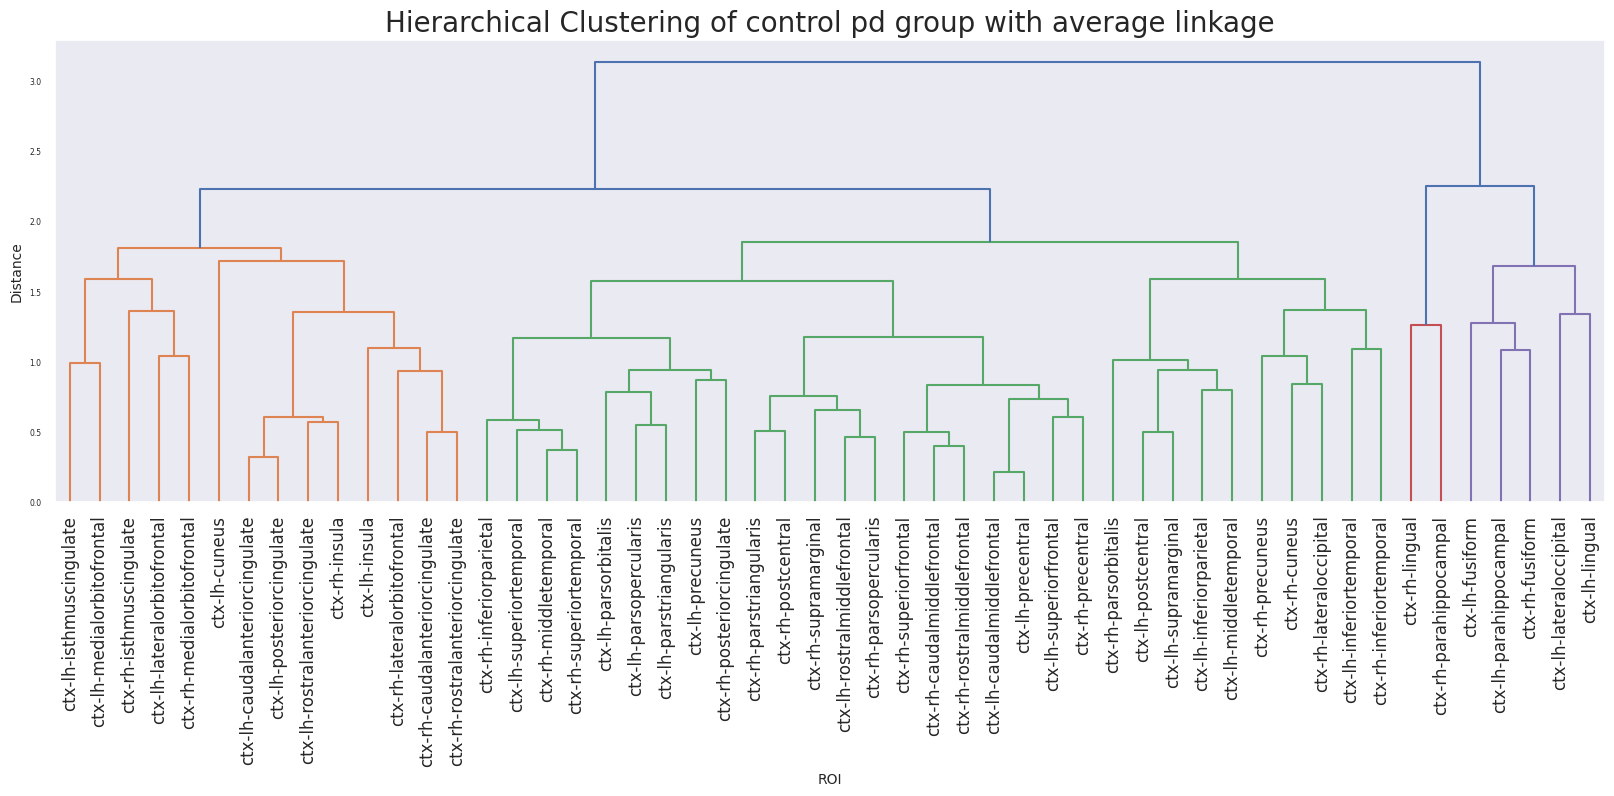

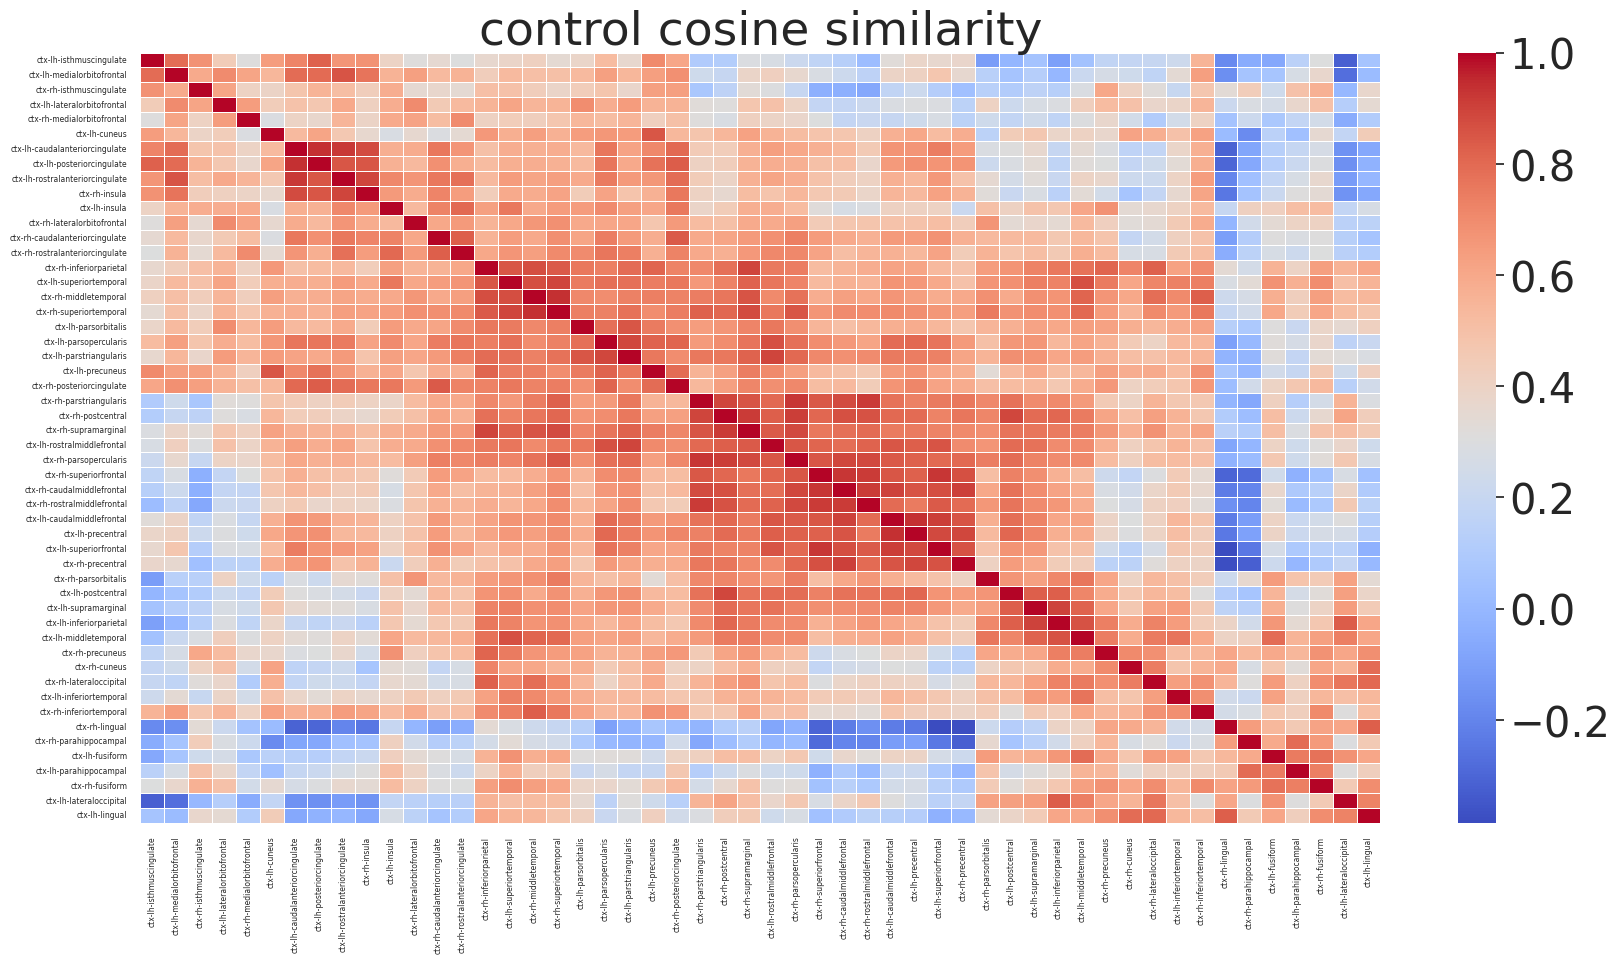

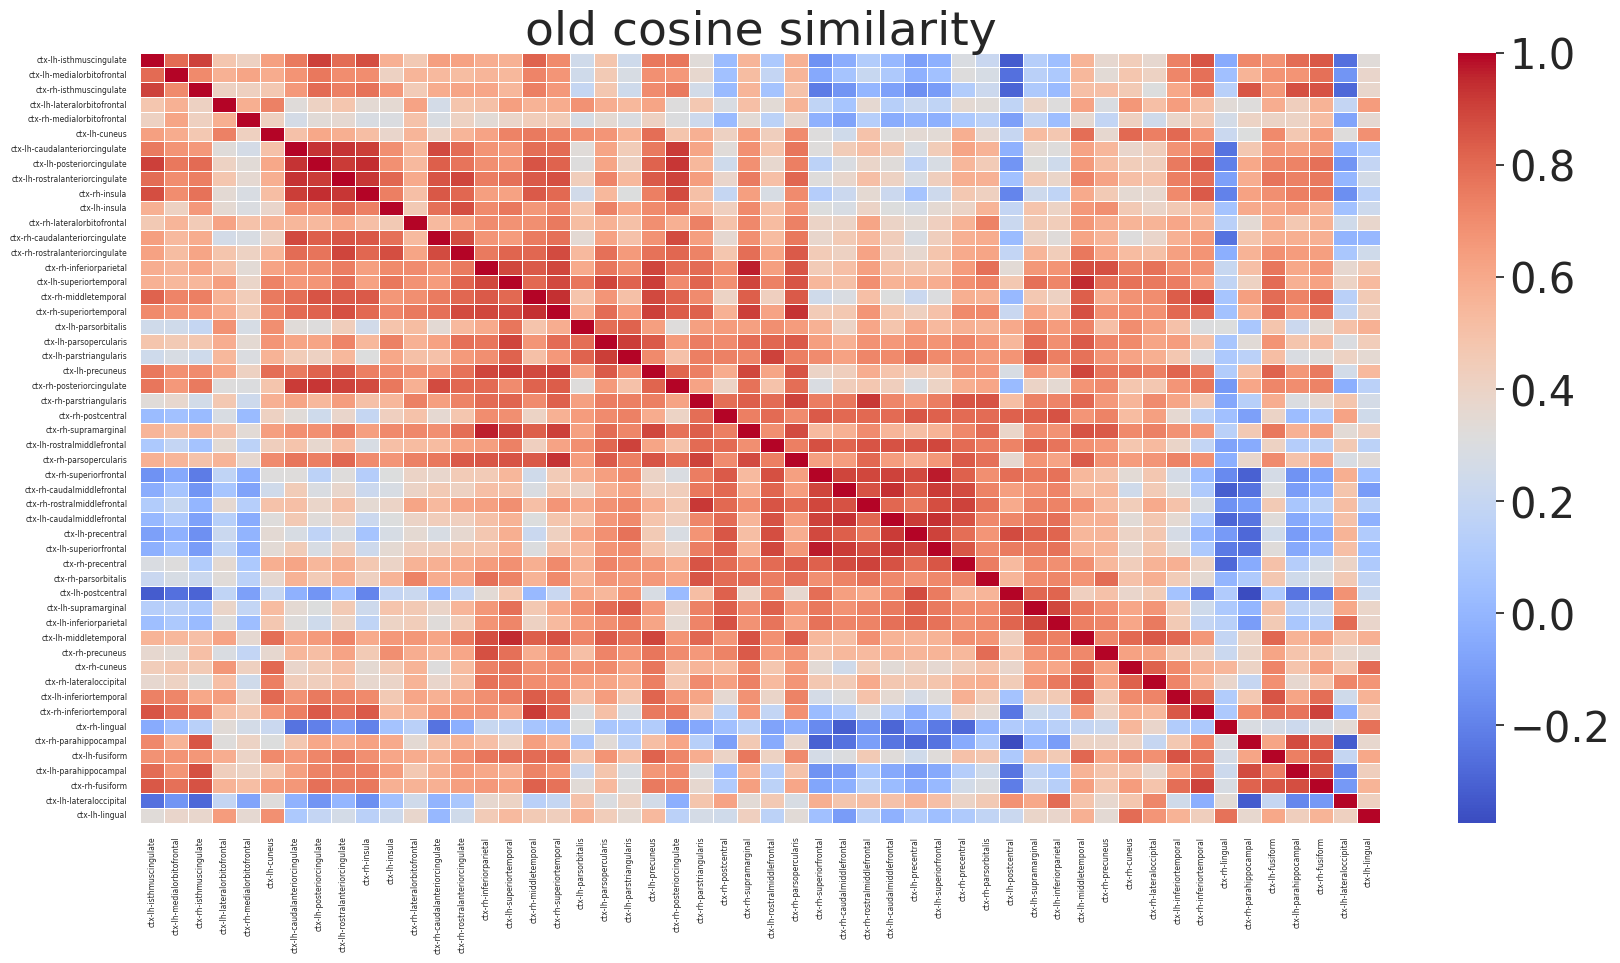

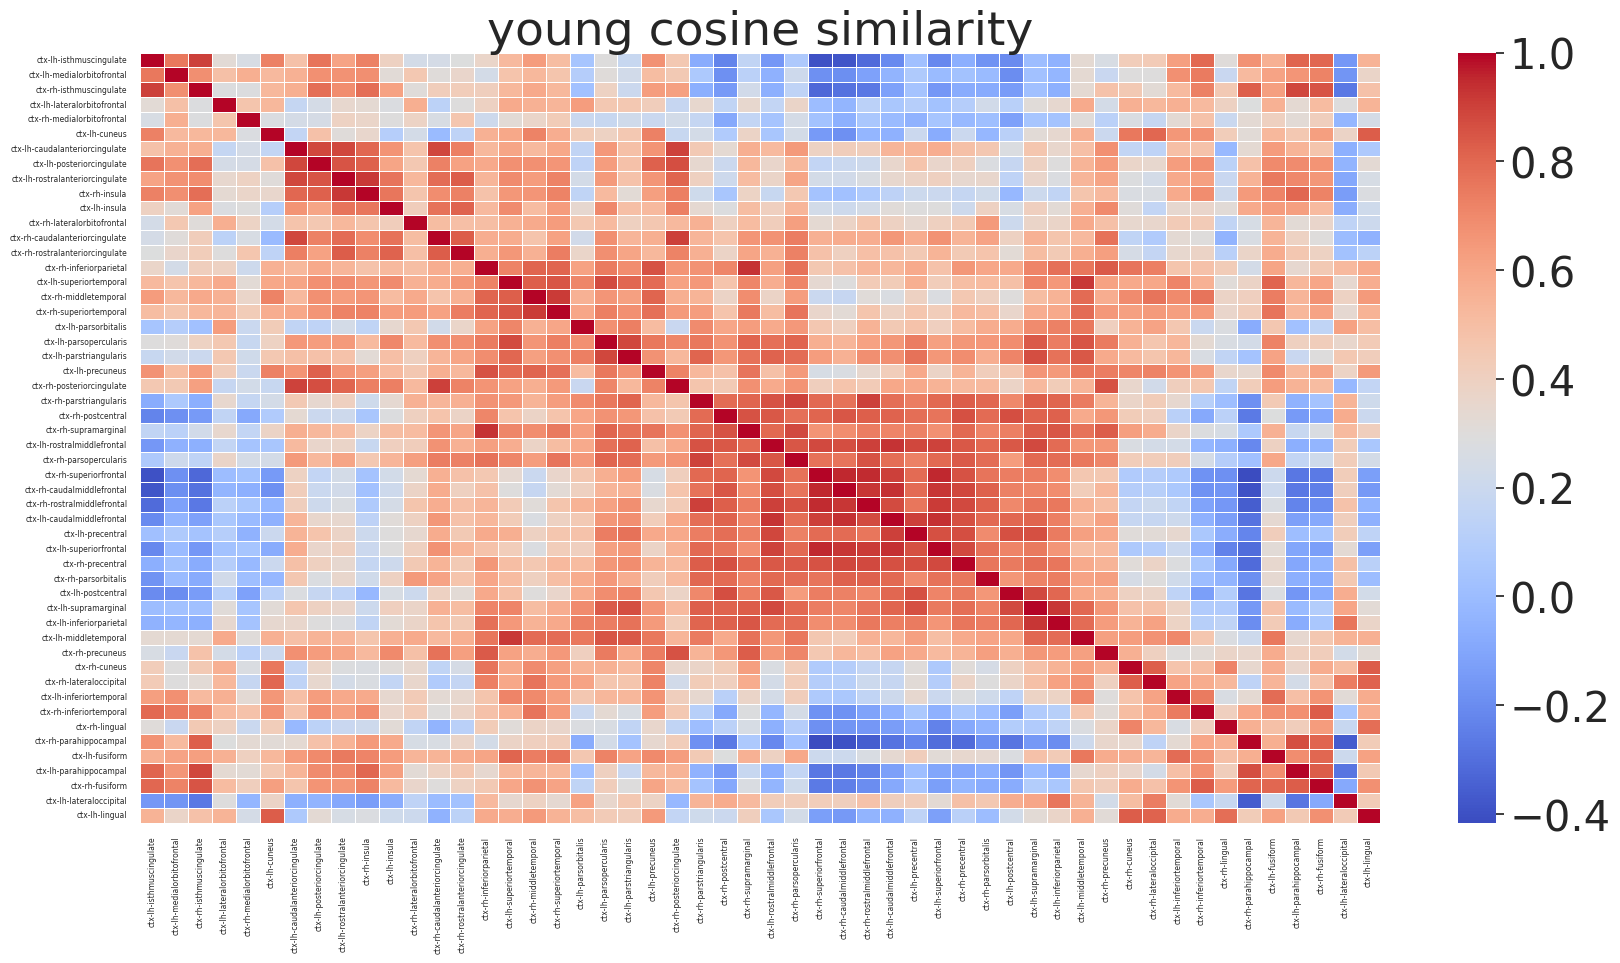

In [16]:
ctl_clustring_data =  StatisticsWrapper.hierarchical_clustering(ctl_data_z_score, params_to_work_with, 'average',
                                                            title="control pd")['dendrogram_data']['ivl']
ctl_distances = StatisticsWrapper.roi_distances(
    ctl_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'control cosine similarity')

old_distances = StatisticsWrapper.roi_distances(
    old_ctx_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'old cosine similarity')

young_distances = StatisticsWrapper.roi_distances(
    young_ctx_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'young cosine similarity')


# _ = show_corr_mean([(young_distances, 'young', 'blue', None), (ctl_distances, 'ctl', 'green', None)], ctl_clustring_data)
# _ = show_corr_mean([(young_distances, 'young', 'blue',), (old_distances, 'old', 'red')], ctl_clustring_data)
# _ = show_corr_mean([(young_distances, 'young', 'blue'), (ctl_distances, 'ctl', 'green'), (old_distances, 'old', 'red')], ctl_clustring_data)

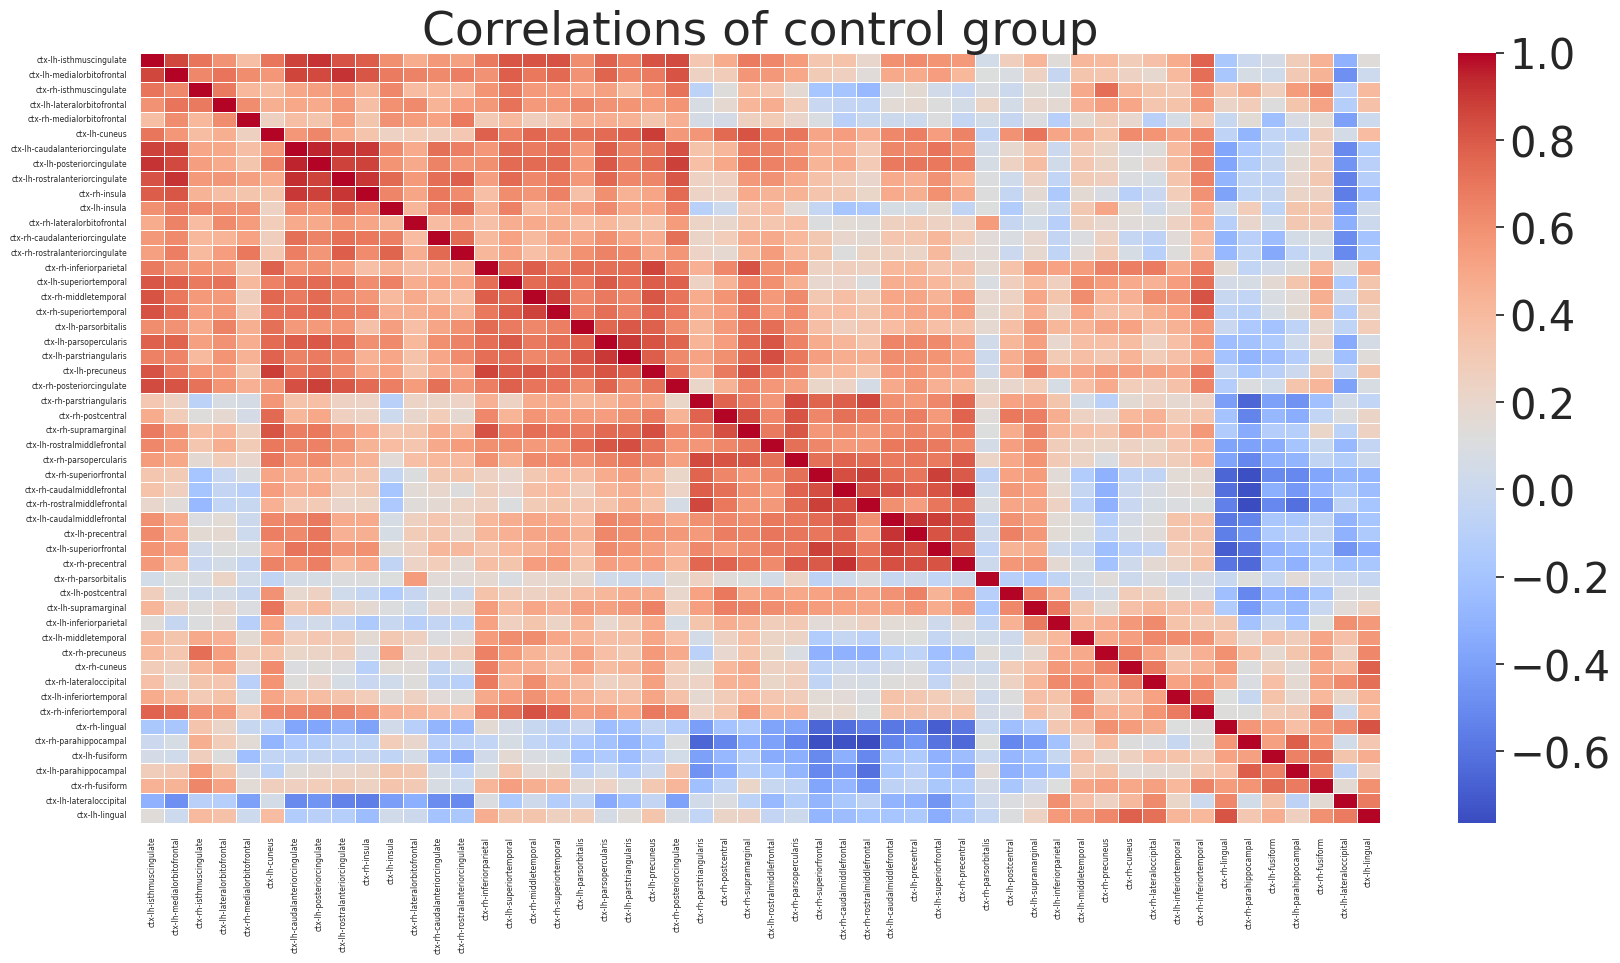

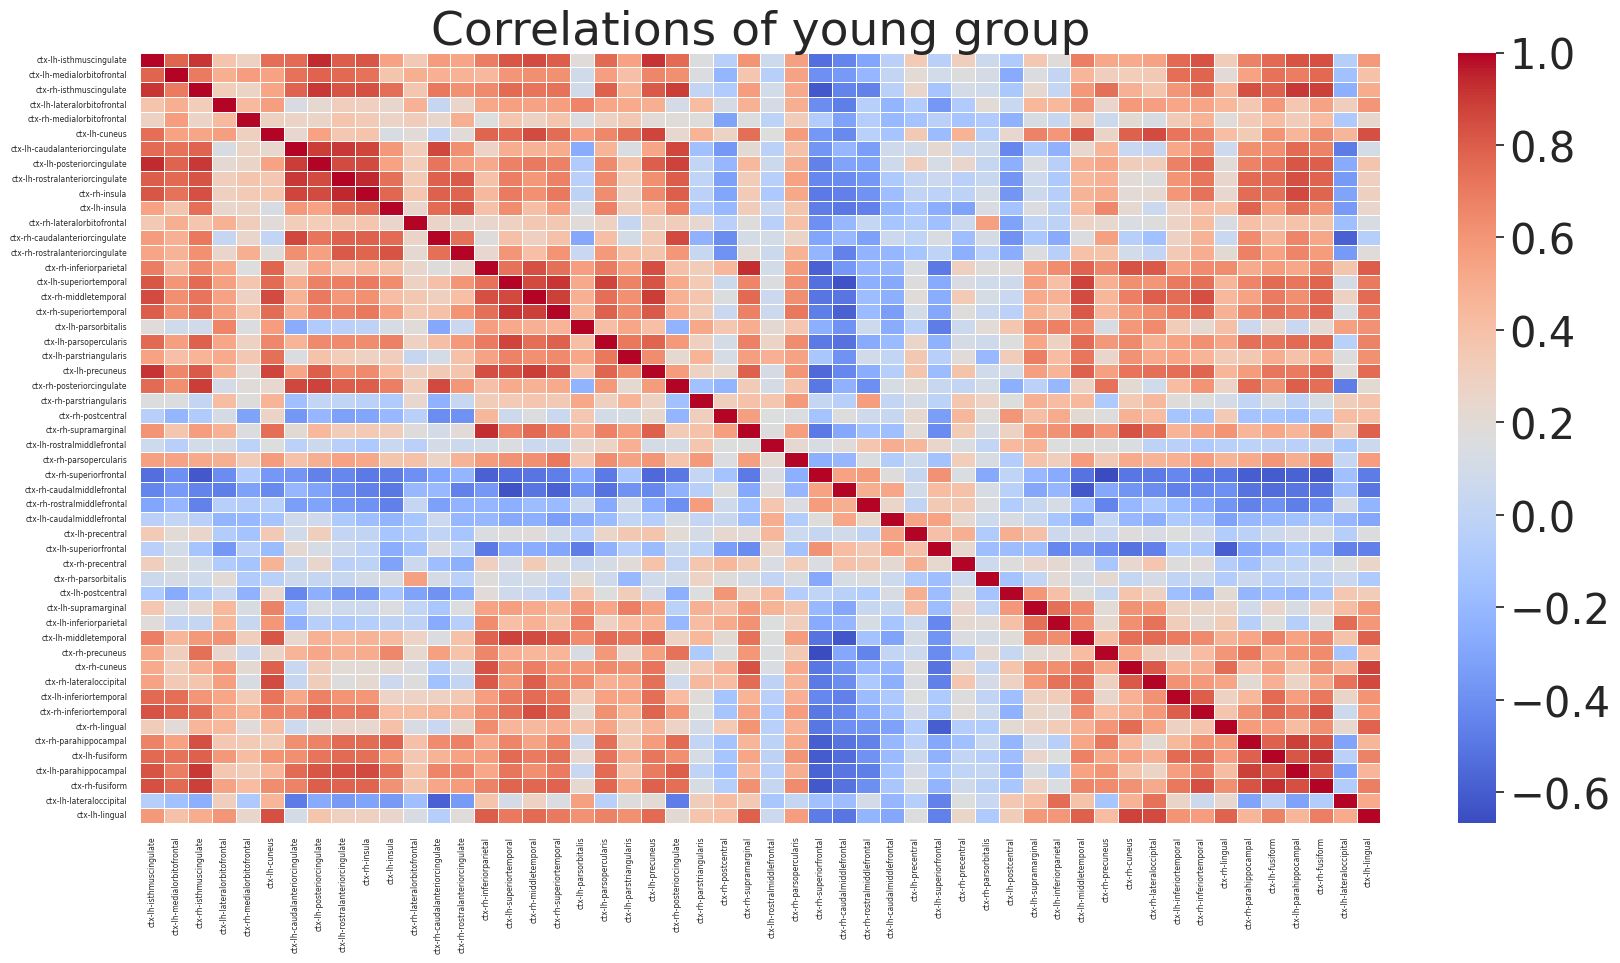

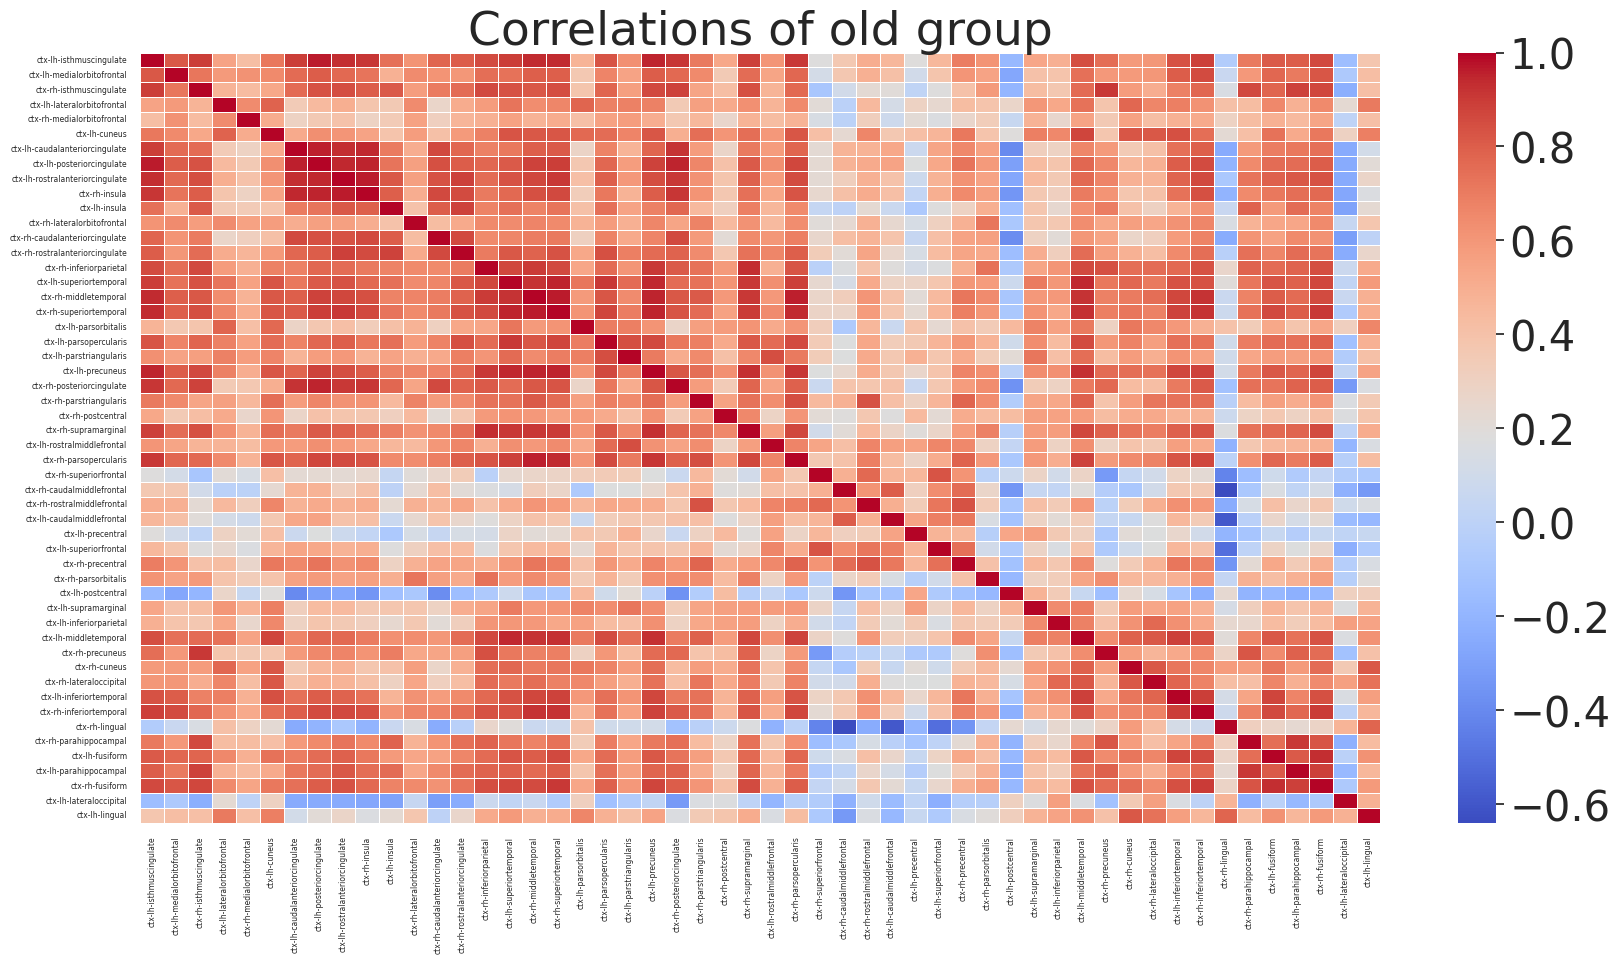

In [17]:
ctl_corr = StatisticsWrapper.roi_correlations(ctl_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of control group')

young_corr = StatisticsWrapper.roi_correlations(young_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of young group')
old_corr = StatisticsWrapper.roi_correlations(old_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of old group')

# _ = show_corr_mean([(young_corr, 'young', 'blue'), (ctl_corr, 'ctl', 'green')], ctl_clustring_data)
# _ = show_corr_mean([(young_corr, 'young', 'blue'), (old_corr, 'old', 'red')], ctl_clustring_data)
# _ = show_corr_mean([(young_corr, 'young', 'blue'), (ctl_corr, 'ctl', 'green'), (old_corr, 'old', 'red')], ctl_clustring_data)


In [ ]:
frobenius_norm = np.linalg.norm(young_distances - ctl_distances, 'fro')
print(f'Frobenius norm: {frobenius_norm}')

Frobenius norm: 10.280120968490454


## Boostraping and k-fold

In [8]:
def bootstrap_correlation_matrices(df, rois_order, metric='corr', n_bootstrap=1000):
    """
    Perform bootstrapping on the correlation matrices.
    :param df: DataFrame containing the data.
    :param n_bootstrap: Number of bootstrap iterations.
    :return: Bootstrap samples of average correlation matrices.
    """
    subjects = df['subjects'].unique()
    n_subjects = len(subjects)
    n_regions = df['ROI'].nunique()
    bootstrap_samples = np.zeros((n_bootstrap, n_regions, n_regions))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        resampled_subjects = np.random.choice(subjects, n_subjects, replace=True)
        resampled_df = pd.DataFrame()

        for j, subject in enumerate(resampled_subjects):
            subject_data = df[df['subjects'] == subject].copy()
            # Create a unique identifier for the resampled subject
            subject_data['subjects'] = f"{subject}_resampled_{j}"
            resampled_df = pd.concat([resampled_df, subject_data], ignore_index=True)

        if metric == 'corr':
            res = StatisticsWrapper.roi_correlations(resampled_df, params_to_work_with, rois_order,
                                                          group_title='', show=False).to_numpy()
        elif metric == 'distance':
            res = StatisticsWrapper.roi_distances(
                    resampled_df, params_to_work_with, rois_order, method=cosine_similarity, title=f'', show=False).to_numpy()
            
        bootstrap_samples[i] = res

    return bootstrap_samples

def analyze_bootstrap_results(bootstrap_samples, columns, confidence_level=95):
    mean_matrix = pd.DataFrame(
            np.mean(bootstrap_samples, axis=0), index=columns, columns=columns)
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile

    lower_ci_matrix = pd.DataFrame(
        np.percentile(bootstrap_samples, lower_percentile, axis=0), index=columns, columns=columns)
    upper_ci_matrix = pd.DataFrame(
        np.percentile(bootstrap_samples, upper_percentile, axis=0), index=columns, columns=columns)
 
    return mean_matrix, lower_ci_matrix, upper_ci_matrix

def k_fold_correlation_matrices(df, rois_order, n_folds=3):
    """
    Perform k-fold cross-validation on the correlation matrices.
    :param df: DataFrame containing the data.
    :param n_folds: Number of folds for cross-validation.
    :return: Average correlation matrices from cross-validation.
    """
    subjects = df['subjects'].unique()
    n_subjects = len(subjects)
    n_regions = df['ROI'].nunique()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_samples = np.zeros((n_folds, n_regions, n_regions))

    for i, (train_index, test_index) in enumerate(kf.split(subjects)):
        # Get training and testing subjects
        train_subjects = subjects[train_index]
        test_subjects = subjects[test_index]

        # Create a DataFrame for the current fold
        train_df = df[df['subjects'].isin(train_subjects)].copy()
        test_df = df[df['subjects'].isin(test_subjects)].copy()

        res = StatisticsWrapper.roi_correlations(train_df, params_to_work_with, rois_order,
                                                    group_title='', show=False)

        fold_samples[i] = res

    # Return the average of the correlation matrices from each fold
    average_correlation_matrix = np.mean(fold_samples, axis=0)
    return average_correlation_matrix


In [9]:
young_bootstrap_corrs = bootstrap_correlation_matrices(young_ctx_data_z_score, ctl_clustring_data, metric='corr', n_bootstrap=1000)
old_bootstrap_corrs = bootstrap_correlation_matrices(old_ctx_data_z_score, ctl_clustring_data, metric='corr', n_bootstrap=1000)

In [10]:
young_mean_matrix, young_lower_ci, young_upper_ci = analyze_bootstrap_results(young_bootstrap_corrs, ctl_clustring_data)
old_mean_matrix, old_lower_ci, old_upper_ci = analyze_bootstrap_results(old_bootstrap_corrs, ctl_clustring_data)

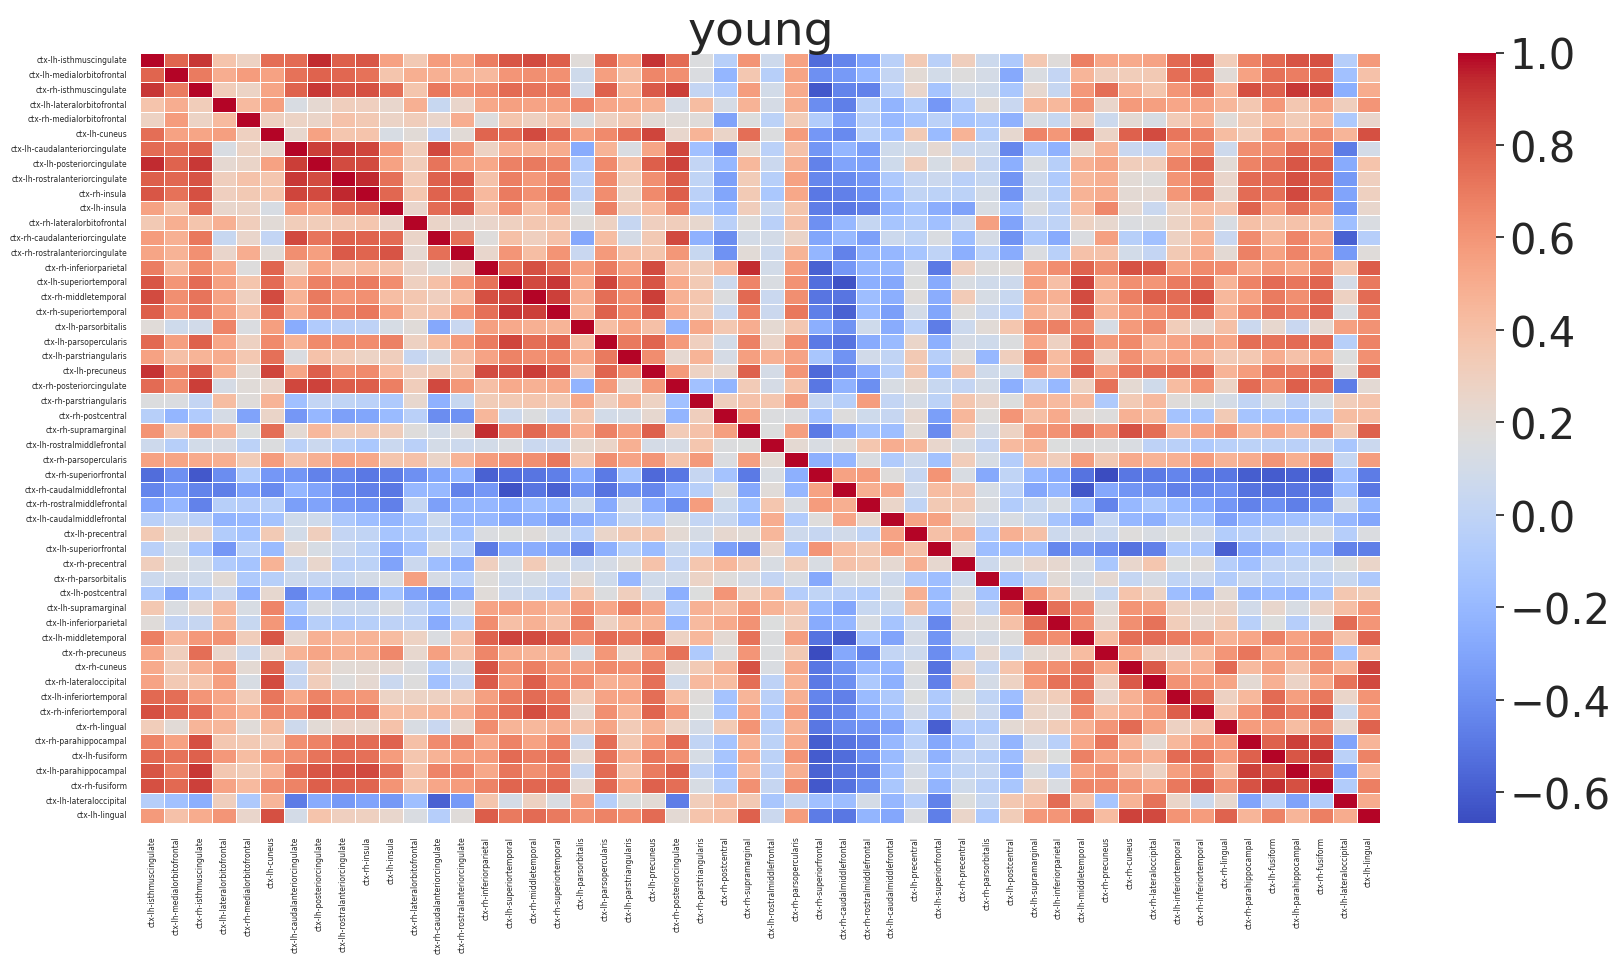

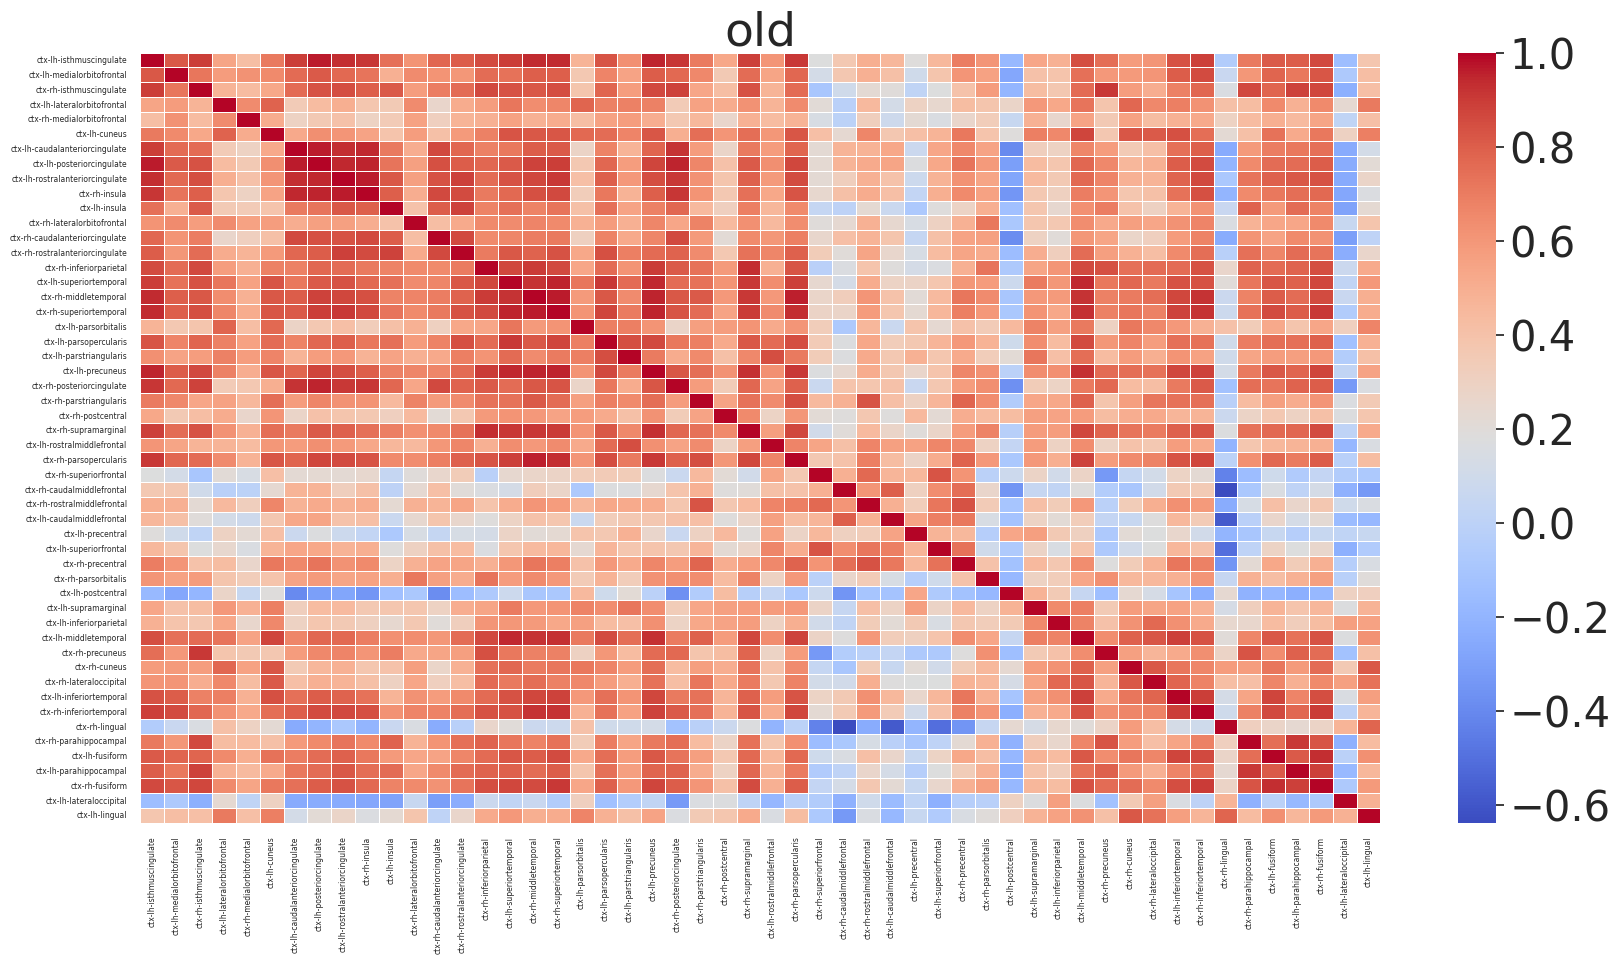

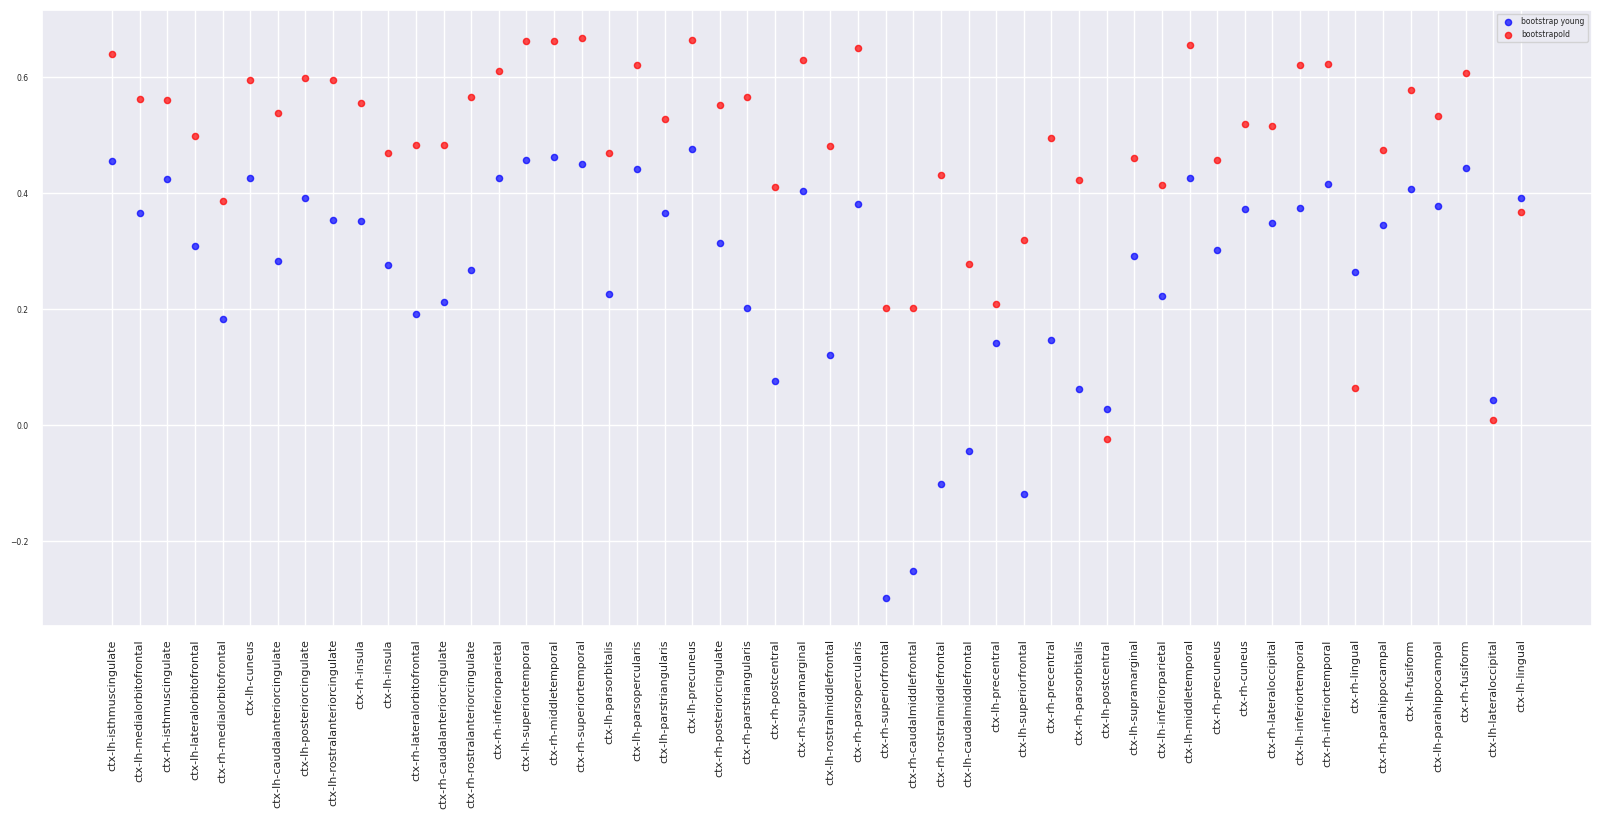

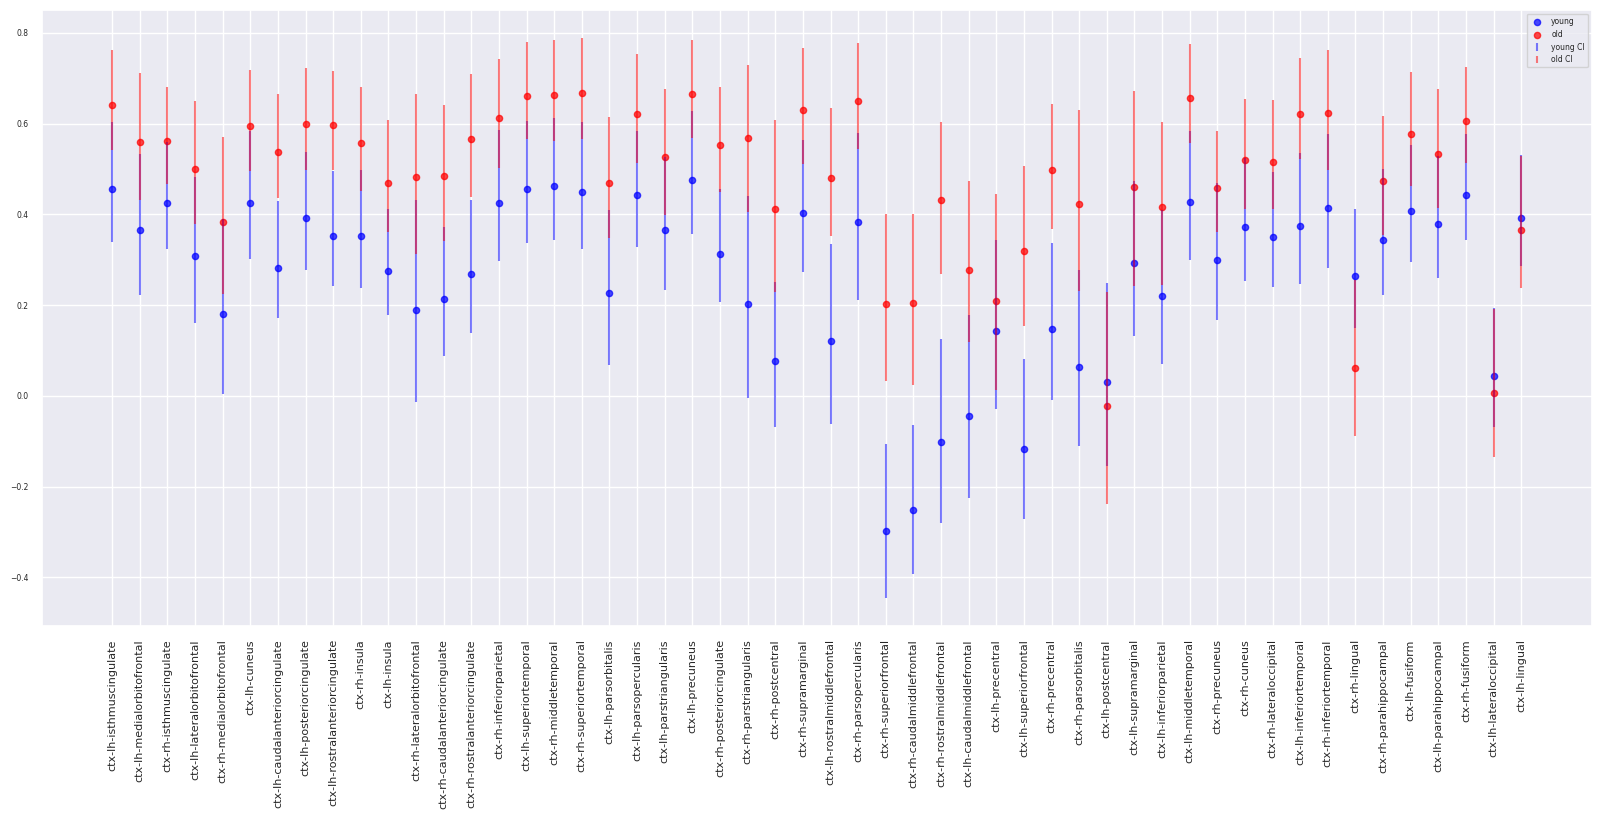

In [20]:
# young_corr = StatisticsWrapper.roi_correlations(young_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
#                                                           group_title='', show=False)
# old_corr = StatisticsWrapper.roi_correlations(old_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
#                                                           group_title='', show=False)

PlotsManager.plot_heatmap(young_mean_matrix, 'young')
PlotsManager.plot_heatmap(old_mean_matrix, 'old')
# PlotsManager.plot_heatmap(young_mean_matrix-young_corr, 'young diff')

_ = show_corr_mean([(young_mean_matrix, 'bootstrap young', 'blue', None), (old_mean_matrix, 'bootstrapold', 'red', None)], ctl_clustring_data)

# _ = show_corr_mean([(young_mean_matrix, 'young mean', 'blue', {"lower_ci": young_lower_ci, "upper_ci": young_upper_ci})]
#                    , ctl_clustring_data)
_ = show_corr_mean([(young_corr, 'young', 'blue', {"lower_ci": young_lower_ci, "upper_ci": young_upper_ci}),
                    (old_corr, 'old', 'red', {"lower_ci": old_lower_ci, "upper_ci": old_upper_ci})]
                   , ctl_clustring_data)
# _ = show_corr_mean([(old_mean_matrix, 'old mean', 'red'), (old_lower_ci, 'old lower ci', 'orange'), (old_upper_ci, 'old upper ci', 'orange')], 
#                    ctl_clustring_data)

# _ = show_corr_mean([(young_mean_matrix, 'young mean', 'blue'), (young_lower_ci, 'young lower ci', 'green'), (young_upper_ci, 'young upper ci', 'green'),
#                     (old_mean_matrix, 'old mean', 'red'), (old_lower_ci, 'old lower ci', 'orange'), (old_upper_ci, 'old upper ci', 'orange')], ctl_clustring_data)
# _ = show_corr_mean([(old_mean_matrix, 'bootstrap old', 'blue'), (old_corr, 'original old', 'red')], ctl_clustring_data)
# _ = show_corr_mean([(young_mean_matrix, 'bootstrap young', 'blue'), (young_corr, 'original young', 'red')], ctl_clustring_data)
